In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import all the necessary packages**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model

Test whether the GPU is active or not

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from keras.preprocessing import image as image_utils
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Input, MaxPooling2D, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras.optimizers import Adam, SGD 

In [ ]:
import json
import numpy as np
import pandas as pd
import argparse
import os 
from os.path import isfile, join
from random import shuffle
from PIL import Image
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from scipy.io import wavfile
import h5py
import random
import pickle
!pip3 install pickle5
import pickle5 as p
from sklearn.model_selection import train_test_split


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 13.7 MB/s 


In [ ]:
print("TF version is:",tf.__version__)
print("h5py version is:",h5py.__version__)

TF version is: 2.8.0
h5py version is: 3.1.0


# **Load the german dataset that has already been separated to train/set/val sets. Observe that the same patient will be in the same dataset**

In [ ]:
with open('/content/drive/MyDrive/CS230_Code_Data/OLD/german_data_correctly_split_train.json', 'rb') as fp:
    dataset_train = pickle.load(fp)

with open('/content/drive/MyDrive/CS230_Code_Data/OLD/german_data_correctly_split_val.json', 'rb') as fp:
    dataset_val = pickle.load(fp)

with open('/content/drive/MyDrive/CS230_Code_Data/OLD/german_data_correctly_split_test.json', 'rb') as fp:
    dataset_test = pickle.load(fp)

In [ ]:
def create_dataset(dataset):
    X = []
    y = []

    for person in dataset:
        spectogram = person['spectogram']  #/np.float32(255)
        status = int(person['status'])   # Look whether the person is pathalogical or not
        X.append(spectogram)
        y.append(status)

    X = np.array(X)
    y = np.array(y)

    y = y.reshape((len(dataset),1))
    #X = X.reshape((296, 28, 28, 1))
    print('X shape: ', X.shape, ',y shape: ', y.shape)
    return X, y

In [ ]:
train_data, train_label = create_dataset(dataset_train)
test_data, test_label = create_dataset(dataset_test)
val_data, val_label = create_dataset(dataset_val)

X shape:  (2912, 224, 224, 3) ,y shape:  (2912, 1)
X shape:  (550, 224, 224, 3) ,y shape:  (550, 1)
X shape:  (620, 224, 224, 3) ,y shape:  (620, 1)


# **Construct the model**

In [ ]:
# WHAT TO DO? CHANGE THIS TO THE FORM IN https://www.coursera.org/learn/convolutional-neural-networks/ungradedLab/mMcLP/keras-tutorial-not-graded/lab?path=%2Fnotebooks%2Fweek2%2FKerasTutorial%2FKeras_Tutorial_v2a.ipynb

###

initializer = tf.keras.initializers.GlorotNormal() # Xavier initialization

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), name = 'conv_1', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), strides=(2, 2), activation='relu', padding='same', name = 'conv_2', kernel_initializer=initializer))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same', name= 'conv_3', kernel_initializer=initializer))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(4, (3, 3), activation='relu', padding='same', name= 'conv_4'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))
model.add(layers.AveragePooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))

model.add(layers.Dense(16, activation='elu', name='Dense_layer'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate = 0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

###

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 56, 56, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 16)       64        
 hNormalization)                                                 
                                                        

# **Compile the model and train the german dataset**

In [ ]:
opt = Adam(learning_rate=5e-5)#, decay = 0.9)
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [ ]:
# Finaly fit the data
history = model.fit(train_data, train_label, epochs=40, validation_data=(val_data,val_label), class_weight={0:1.5, 1:1}) # May be increase epochs since the val loss still is decreasing

Epoch 1/40
91/91 [==============================] - 17s 33ms/step - loss: 1.0845 - accuracy: 0.5003 - precision: 0.6556 - recall: 0.4968 - val_loss: 0.6548 - val_accuracy: 0.6210 - val_precision: 0.7076 - val_recall: 0.7900
Epoch 2/40
91/91 [==============================] - 2s 27ms/step - loss: 1.0224 - accuracy: 0.5240 - precision: 0.6799 - recall: 0.5142 - val_loss: 0.6232 - val_accuracy: 0.6855 - val_precision: 0.7113 - val_recall: 0.9338
Epoch 3/40
91/91 [==============================] - 2s 27ms/step - loss: 1.0055 - accuracy: 0.5354 - precision: 0.6850 - recall: 0.5357 - val_loss: 0.6476 - val_accuracy: 0.6468 - val_precision: 0.7126 - val_recall: 0.8379
Epoch 4/40
91/91 [==============================] - 2s 27ms/step - loss: 1.0056 - accuracy: 0.5196 - precision: 0.6724 - recall: 0.5173 - val_loss: 0.6772 - val_accuracy: 0.5597 - val_precision: 0.7132 - val_recall: 0.6301
Epoch 5/40
91/91 [==============================] - 2s 27ms/step - loss: 0.9817 - accuracy: 0.5495 - precis

In [ ]:
acc_first_train = history.history["accuracy"]
acc_first_val = history.history["val_accuracy"]

In [ ]:
# Change the weights and fit again
history = model.fit(train_data, train_label, epochs=40, validation_data=(val_data,val_label), class_weight={0:1.2, 1:1}) # May be increase epochs since the val loss still is decreasing

Epoch 1/40
91/91 [==============================] - 3s 28ms/step - loss: 0.7004 - accuracy: 0.6350 - precision: 0.7559 - recall: 0.6523 - val_loss: 0.6240 - val_accuracy: 0.6500 - val_precision: 0.7812 - val_recall: 0.7009
Epoch 2/40
91/91 [==============================] - 3s 28ms/step - loss: 0.7034 - accuracy: 0.6336 - precision: 0.7501 - recall: 0.6591 - val_loss: 0.6008 - val_accuracy: 0.6726 - val_precision: 0.7594 - val_recall: 0.7854
Epoch 3/40
91/91 [==============================] - 2s 26ms/step - loss: 0.6882 - accuracy: 0.6408 - precision: 0.7541 - recall: 0.6686 - val_loss: 0.6164 - val_accuracy: 0.6323 - val_precision: 0.7638 - val_recall: 0.6941
Epoch 4/40
91/91 [==============================] - 2s 26ms/step - loss: 0.6878 - accuracy: 0.6490 - precision: 0.7597 - recall: 0.6775 - val_loss: 0.6022 - val_accuracy: 0.6581 - val_precision: 0.7557 - val_recall: 0.7626
Epoch 5/40
91/91 [==============================] - 2s 26ms/step - loss: 0.6911 - accuracy: 0.6494 - precisi

In [ ]:
acc_second_train = history.history["accuracy"]
acc_second_val = history.history["val_accuracy"]

In [ ]:
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_data, test_label)
print('acc:', test_acc)
print('recall:', test_recall)
print('precision:', test_prec)

18/18 [==============================] - 0s 12ms/step - loss: 0.5638 - accuracy: 0.7055 - precision: 0.7476 - recall: 0.8415
acc: 0.7054545283317566
recall: 0.8415300250053406
precision: 0.7475728392601013


In [ ]:
model.save_weights('/content/drive/MyDrive/CS230_Code_Data/Dataset/german_model.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/CS230_Code_Data/Dataset/german_model.h5')

In [ ]:
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_data, test_label)
print('acc:', test_acc)
print('recall:', test_recall)
print('precision:', test_prec)

18/18 [==============================] - 0s 12ms/step - loss: 0.5638 - accuracy: 0.7055 - precision: 0.7476 - recall: 0.8415
acc: 0.7054545283317566
recall: 0.8415300250053406
precision: 0.7475728392601013


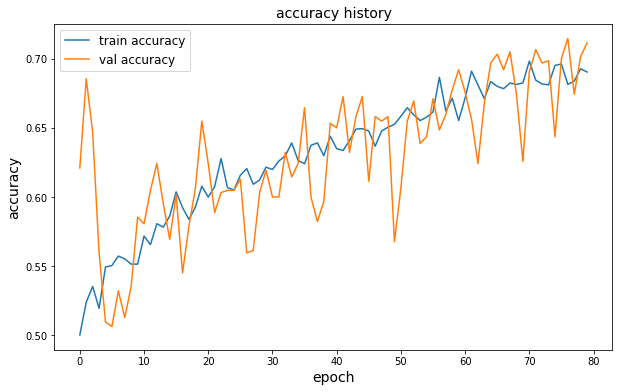

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10,6))
acc_train = acc_first_train + acc_second_train
acc_val = acc_first_val + acc_second_val
plt.plot(acc_train, label="train accuracy")
plt.plot(acc_val, label="val accuracy")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('accuracy history', fontsize=14)
plt.legend(fontsize='large')

f.savefig('accuracy_history_german.pdf', bbox_inches='tight')

# **Manage the transfer learning**

In [ ]:
base_model = model
prefinal_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv_4').output, name = 'prefinal_model')
prefinal_model.summary()

Model: "prefinal_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 56, 56, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 16)    

In [ ]:
X = prefinal_model.output    # x is the output of the last layer of cutted_layer (x=features on layer block4_conv3)

X = Dropout(0.3)(X)
X = BatchNormalization()(X)
X = MaxPooling2D((2,2))(X)
X = Flatten()(X)
X = Dropout(0.3)(X)
X = Dense(16, activation='elu')(X) 
X = Dense(4, activation='elu')(X) 
prediction = Dense(1, activation='sigmoid')(X) 



In [ ]:
final_model = Model(inputs=base_model.input, outputs=prediction, name = 'finale')
final_model.summary()

Model: "finale"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 56, 56, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 16)       64   

In [ ]:
for layer in prefinal_model.layers:
    layer.trainable = True

In [ ]:
"""
# RUN THIS CELL FOR 10 DIFFERENT COLOR AUGMENTATION
with open('/content/drive/MyDrive/CS230_Code_Data/Dataset/splitted_train.json', 'rb') as su:
    train_data_dict = pickle.load(su)

with open('/content/drive/MyDrive/CS230_Code_Data/Dataset/splitted_test.json', 'rb') as su:
    test_data_dict = pickle.load(su)

with open('/content/drive/MyDrive/CS230_Code_Data/Dataset/splitted_val.json', 'rb') as su:
    val_data_dict = pickle.load(su)
"""

"\n# RUN THIS CELL FOR 10 DIFFERENT COLOR AUGMENTATION\nwith open('/content/drive/MyDrive/CS230_Code_Data/Dataset/splitted_train.json', 'rb') as su:\n    train_data_dict = pickle.load(su)\n\nwith open('/content/drive/MyDrive/CS230_Code_Data/Dataset/splitted_test.json', 'rb') as su:\n    test_data_dict = pickle.load(su)\n\nwith open('/content/drive/MyDrive/CS230_Code_Data/Dataset/splitted_val.json', 'rb') as su:\n    val_data_dict = pickle.load(su)\n"

In [ ]:
"""
# RUN THIS CELL IF YOU WANT TO TEST THE SCENARIO WITH 3 combined 
with open('/content/drive/MyDrive/CS230_Code_Data/Dataset/splitted_train_3comb.json', 'rb') as su:
    train_data_dict = pickle.load(su)

with open('/content/drive/MyDrive/CS230_Code_Data/Dataset/splitted_test_3comb.json', 'rb') as su:
    test_data_dict = pickle.load(su)

with open('/content/drive/MyDrive/CS230_Code_Data/Dataset/splitted_val_3comb.json', 'rb') as su:
    val_data_dict = pickle.load(su)
"""

In [ ]:

# RUN THIS CELL IF YOU WANT TO TEST THE SCENARIO WITH NO COLOR CHANGE (NO AUGMENTATION)
with open('/content/drive/MyDrive/CS230_Code_Data/Dataset/no_color_change_5_comb_train', 'rb') as su:
    train_data_dict = pickle.load(su)

with open('/content/drive/MyDrive/CS230_Code_Data/Dataset/no_color_change_5_comb_test', 'rb') as su:
    test_data_dict = pickle.load(su)

with open('/content/drive/MyDrive/CS230_Code_Data/Dataset/no_color_change_5_comb_val', 'rb') as su:
    val_data_dict = pickle.load(su)


In [ ]:
patient_holder = []
for person in test_data_dict:
    patient = person['patient']
    if patient not in patient_holder:
        patient_holder.append(patient)

In [ ]:
len(patient_holder)

37

In [ ]:
print(len(train_data_dict))
print(len(test_data_dict))
print(len(val_data_dict))

3039
536
566


In [ ]:
def matrix_creator(dataset, augment = False):
    X = []
    y = []
    for person in dataset:
        spectogram = person['spectogram']#/np.float32(255)   #normalize input pixels 
        status = int(person['status'])        # Look whether the person is pathalogical or not
        X.append(spectogram)
        y.append(status)
        if augment:
            for i in range(2):
                spectogram2 = np.copy(spectogram)
                rand2 = random.uniform(0.1, 0.9)
                spectogram2[:,:,2] = spectogram2[:,:,2]*rand2
                X.append(spectogram2)
                y.append(status)

    X = np.array(X)
    y = np.array(y)

    y = y.reshape((y.shape[0],1))
    return X, y

In [ ]:
train_data, train_labels = matrix_creator(train_data_dict, augment = False)  # Set augment = True if want to test augmentation with differnet colors
test_data, test_labels = matrix_creator(test_data_dict)
val_data, val_labels = matrix_creator(val_data_dict)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(3039, 224, 224, 3)
(536, 224, 224, 3)
(566, 224, 224, 3)


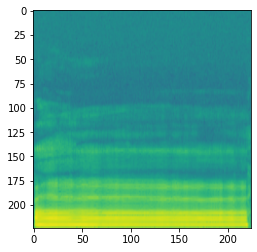

In [ ]:
image = train_data[26]
plt.imshow(image)
plt.show()

# **Train on the stanford patient dataset, which is our main goal to have good metrics on**

In [ ]:
opt = Adam(learning_rate=5e-5, beta_1 = 0.9, beta_2 = 0.999)
final_model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [ ]:
history = final_model.fit(train_data, train_labels, epochs=20, batch_size=16, class_weight={0:13, 1:10}, validation_data=(val_data, val_labels))

Epoch 1/20
190/190 [==============================] - 5s 19ms/step - loss: 10.0520 - accuracy: 0.5278 - precision_1: 0.6402 - recall_1: 0.5997 - val_loss: 0.7519 - val_accuracy: 0.5336 - val_precision_1: 0.6254 - val_recall_1: 0.6074
Epoch 2/20
190/190 [==============================] - 3s 15ms/step - loss: 9.3362 - accuracy: 0.5380 - precision_1: 0.6542 - recall_1: 0.5910 - val_loss: 0.7304 - val_accuracy: 0.5318 - val_precision_1: 0.6500 - val_recall_1: 0.5215
Epoch 3/20
190/190 [==============================] - 3s 16ms/step - loss: 8.9449 - accuracy: 0.5357 - precision_1: 0.6529 - recall_1: 0.5868 - val_loss: 0.7103 - val_accuracy: 0.5477 - val_precision_1: 0.6576 - val_recall_1: 0.5559
Epoch 4/20
190/190 [==============================] - 3s 16ms/step - loss: 8.5397 - accuracy: 0.5689 - precision_1: 0.6761 - recall_1: 0.6274 - val_loss: 0.7031 - val_accuracy: 0.5636 - val_precision_1: 0.7008 - val_recall_1: 0.5100
Epoch 5/20
190/190 [==============================] - 3s 15ms/step 

In [ ]:
acc_first_train = history.history["accuracy"]
acc_first_val = history.history["val_accuracy"]

In [ ]:
opt = Adam(learning_rate=5e-5, beta_1 = 0.9, beta_2 = 0.999) # decrease the learning rate and run for 20 more epochs
history = final_model.fit(train_data, train_labels, epochs=30, batch_size=16, class_weight={0:11, 1:10}, validation_data=(val_data, val_labels))

Epoch 1/30
190/190 [==============================] - 3s 16ms/step - loss: 6.5375 - accuracy: 0.6578 - precision_1: 0.7147 - recall_1: 0.7749 - val_loss: 0.6132 - val_accuracy: 0.6449 - val_precision_1: 0.7114 - val_recall_1: 0.7135
Epoch 2/30
190/190 [==============================] - 3s 15ms/step - loss: 6.5507 - accuracy: 0.6479 - precision_1: 0.7030 - recall_1: 0.7795 - val_loss: 0.6132 - val_accuracy: 0.6396 - val_precision_1: 0.7066 - val_recall_1: 0.7106
Epoch 3/30
190/190 [==============================] - 3s 16ms/step - loss: 6.4067 - accuracy: 0.6680 - precision_1: 0.7154 - recall_1: 0.7996 - val_loss: 0.6130 - val_accuracy: 0.6590 - val_precision_1: 0.7143 - val_recall_1: 0.7450
Epoch 4/30
190/190 [==============================] - 3s 15ms/step - loss: 6.4940 - accuracy: 0.6538 - precision_1: 0.7047 - recall_1: 0.7909 - val_loss: 0.6160 - val_accuracy: 0.6484 - val_precision_1: 0.7107 - val_recall_1: 0.7249
Epoch 5/30
190/190 [==============================] - 3s 15ms/step -

In [ ]:
acc_second_train = history.history["accuracy"]
acc_second_val = history.history["val_accuracy"]

In [ ]:
"""
"make space in ram"
del(train_data)
del(val_data)
"""

'\n"make space in ram"\ndel(train_data)\ndel(val_data)\n'

In [ ]:
test_loss, test_acc, test_prec, test_recall = final_model.evaluate(test_data, test_labels)
print('acc:', test_acc)
print('recall:', test_recall)
print('precision:', test_prec)

"""
OLD BEST:
19/19 [==============================] - 0s 13ms/step - loss: 0.5331 - accuracy: 0.7440 - precision_3: 0.7709 - recall_3: 0.8148
acc: 0.744027316570282
recall: 0.8148148059844971
precision: 0.7708894610404968
"""

17/17 [==============================] - 0s 12ms/step - loss: 0.5049 - accuracy: 0.7388 - precision_1: 0.7696 - recall_1: 0.8722
acc: 0.7388059496879578
recall: 0.8722222447395325
precision: 0.7696078419685364


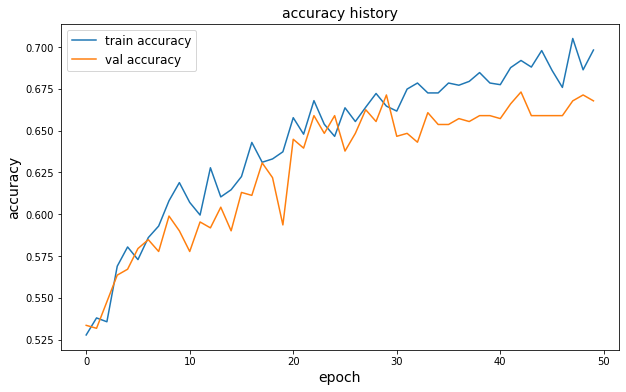

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(10,6))
acc_train = acc_first_train + acc_second_train
acc_val = acc_first_val + acc_second_val
plt.plot(acc_train, label="train accuracy")
plt.plot(acc_val, label="val accuracy")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('accuracy history', fontsize=14)
plt.legend(fontsize='large')

f.savefig('accuracy_history.pdf', bbox_inches='tight')

In [ ]:
model.save_weights('/content/drive/MyDrive/CS230_Code_Data/Dataset/su_model.h5')

# **Preprocessing for comparing the GT and the estimated values**

In [ ]:
amount = {}
prediction_dict = {}
keys = []

for test_data in test_data_dict:
    patient = test_data['patient']
    spectogram = test_data['spectogram']
    spectogram = np.expand_dims(spectogram, axis = 0)
    prediction = final_model.predict(spectogram)
    prediction = np.round(prediction[0])
    if patient not in prediction_dict:
        prediction_dict[patient] = prediction[0]
        amount[patient] = 1
        keys.append(patient)
    else:     
        prediction_dict[patient] = prediction_dict[patient] + prediction[0]
        amount[patient] = amount[patient] + 1


In [ ]:
predicted_values = {}
for patient in amount:
    mean = prediction_dict[patient]/amount[patient]
    if mean > 0.5:
        predicted_values[patient] = 1
    else: 
        predicted_values[patient] = 0

In [ ]:
print(predicted_values)

{'PT033ENSS': 1, 'PT076_ENSS': 1, 'LA9019_ENSS': 0, 'PT109_ENSS': 1, 'NYU1007_ENSS': 0, 'LA9027_ENSS': 1, 'NYU1025_ENSS': 1, 'LA9004_ENSS': 1, 'PT054_ENSS': 1, 'SJ5004ENSS': 0, 'PT014ENSS': 1, 'PT032ENSS': 1, 'PT121_ENSS': 1, 'SJ2016_ENSS': 1, 'PT113_ENSS': 1, 'BL10_ENSS': 0, 'PT118_ENSS': 1, 'LA9015_ENSS': 1, 'BL06_ENSS': 1, 'PT017ENSS': 1, 'PT094_ENSS': 1, 'PT122_ENSS': 1, 'PT123_ENSS': 1, 'PT087_ENSS': 1, 'PT024ENSS': 1, 'NYU1018_ENSS': 1, 'BL08_ENSS': 0, 'LA7008_ENSS': 1, 'PT100_ENSS': 1, 'PT072_ENSS': 1, 'PT018ENSS': 1, 'PT046_ENSS': 1, 'Sj30003_E_NSS': 0, 'PT010ENSS': 1, 'SJ4002_eNSS': 0, 'PT080_ENSS': 1, 'NYU1020_ENSS': 1}


In [ ]:
path_to_protocol51 = '/content/drive/MyDrive/CS230_Code_Data/Dataset/pandas_audio_labels.pkl'

with open(path_to_protocol51, "rb") as fh:
  stanford = p.load(fh)


In [ ]:
stanford

,File_Name,fs,Amp_number,Total_time,amp,GRBAS_Average,GRBAS_Category
0,LA9013_ENSS,44100.0,1422825.0,32.263605,"[-2, -9, -2, -4, 6, -2, 7, 2, -3, 5, -4, -2, 4...",0.500000,Normal
1,LA9012_ENSS,44100.0,1503889.0,34.101791,"[-9, -12, -10, -1, -6, -8, -9, -2, -4, -10, -6...",0.500000,Normal
2,PT023ENSS,25000.0,538537.0,21.541480,"[0, 0, 0, 0, 1, -2, 2, -2, 2, -1, 1, -2, 2, -2...",0.333333,Normal
3,PT033ENSS,25000.0,442877.0,17.715080,"[-1, 2, -2, 1, 0, -1, 2, -2, 1, -1, 1, 1, -2, ...",0.500000,Normal
4,Sj30006_E_NSS,44100.0,1160192.0,26.308209,"[-5, -5, 0, -3, 1, -3, 2, -3, -1, -1, 1, -2, 3...",0.875000,Mild
...,...,...,...,...,...,...,...
291,LA8002_ENSS,44100.0,1913185.0,43.382880,"[7, -2, 10, 2, 11, 0, 14, 7, 2, 1, 4, 5, 7, -1...",0.833333,Mild
292,Sj4008_ENSS,44100.0,1115557.0,25.296077,"[0, 0, 1, -2, 2, -1, 0, 1, -1, 1, -1, 1, -1, 1...",0.625000,Mild
293,sj4009_ENSS,44100.0,1273049.0,28.867324,"[0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 2, -3, 4, -4, ...",0.625000,Mild
294,PT111_ENSS,25000.0,413427.0,16.537080,"[-1, 3, -4, 5, -5, 3, -1, 0, 1, -1, 1, -2, 3, ...",0.166667,Normal


In [ ]:
def find_status(Condition):
    """Extract the status of the patient
    0: Normal
    1: Pathological"""
    Condition = str(Condition)
    if (Condition == "Normal"):
        return 0
    else:
        return 1

In [ ]:
def find_gt_labels(gt_labels, pandas_data, keys): 
    for index, rows in pandas_data.iterrows():
        if rows.File_Name in keys:
            status = find_status(rows.GRBAS_Category)
            gt_labels[rows.File_Name] = status
    return gt_labels

In [ ]:
gt_labels = {}
gt_labels = find_gt_labels(gt_labels, stanford, keys)

In [ ]:
print(gt_labels)
print(predicted_values)

{'PT033ENSS': 0, 'PT076_ENSS': 1, 'LA9019_ENSS': 0, 'PT109_ENSS': 0, 'NYU1007_ENSS': 0, 'LA9027_ENSS': 1, 'NYU1025_ENSS': 1, 'LA9004_ENSS': 1, 'PT054_ENSS': 1, 'SJ5004ENSS': 0, 'PT014ENSS': 1, 'PT032ENSS': 1, 'PT121_ENSS': 1, 'SJ2016_ENSS': 1, 'PT113_ENSS': 0, 'BL10_ENSS': 0, 'PT118_ENSS': 1, 'LA9015_ENSS': 0, 'BL06_ENSS': 1, 'PT017ENSS': 1, 'PT094_ENSS': 1, 'PT122_ENSS': 1, 'PT123_ENSS': 1, 'PT087_ENSS': 1, 'PT024ENSS': 0, 'NYU1018_ENSS': 1, 'BL08_ENSS': 0, 'LA7008_ENSS': 1, 'PT100_ENSS': 1, 'PT072_ENSS': 1, 'PT018ENSS': 1, 'PT046_ENSS': 1, 'Sj30003_E_NSS': 1, 'PT010ENSS': 0, 'SJ4002_eNSS': 0, 'PT080_ENSS': 1, 'NYU1020_ENSS': 0}
{'PT033ENSS': 1, 'PT076_ENSS': 1, 'LA9019_ENSS': 0, 'PT109_ENSS': 1, 'NYU1007_ENSS': 0, 'LA9027_ENSS': 1, 'NYU1025_ENSS': 1, 'LA9004_ENSS': 1, 'PT054_ENSS': 1, 'SJ5004ENSS': 0, 'PT014ENSS': 1, 'PT032ENSS': 1, 'PT121_ENSS': 1, 'SJ2016_ENSS': 1, 'PT113_ENSS': 1, 'BL10_ENSS': 0, 'PT118_ENSS': 1, 'LA9015_ENSS': 1, 'BL06_ENSS': 1, 'PT017ENSS': 1, 'PT094_ENSS': 1, '

In [ ]:
count = 0
tp = 0
tn = 0
fp = 0
fn = 0
for key in predicted_values:
    count += 1
    our_est = predicted_values[key]
    gt = gt_labels[key]
    if gt == 1 and gt == our_est:
        tp += 1
    elif gt == 1 and gt != our_est:
        fn += 1
    elif gt == 0 and gt == our_est:
        tn += 1
    else:
        fp += 1


acc = (tp + tn)/count
prec = tp/(tp + fp)
recall = tp/(tp + fn)
print('accuracy:', acc)
print('F1 score:', (2*prec*recall)/(prec+ recall))

accuracy: 0.7837837837837838
F1 score: 0.8518518518518519
